# RCによる外力ありのVDPの予測を行う。

まず、ライブラリをインポートする。

In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import reservoirpy as rpy

rpy.verbosity(0)

from reservoirpy.nodes import Reservoir, Ridge

from reservoirpy.observables import nrmse, rsquare

# just a little tweak to center the plots, nothing to worry about
from IPython.core.display import HTML
HTML("""
<style>
.img-center {
    display: block;
    margin-left: auto;
    margin-right: auto;
    }
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
    }
</style>
""")

rpy.set_seed(42)

VDPモデルを数値シミュレーションする。

timestepは2510に設定する。

（内訳：
学習期間は1000ステップ。

テスト期間は1000ステップ。

その後500ステップ弱をGenerative Modelで予測する。
）


In [3]:
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd

In [4]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

def coupled_system(t, state, mu, sigma, rho, beta):
    X, Y, x_lorenz, y_lorenz, z_lorenz = state
    
    dXdt = Y
    dYdt = mu * (1 - X**2) * Y - X + x_lorenz
    
    dx_lorenz_dt = sigma * (y_lorenz - x_lorenz)
    dy_lorenz_dt = x_lorenz * (rho - z_lorenz) - y_lorenz
    dz_lorenz_dt = x_lorenz * y_lorenz - beta * z_lorenz
    
    return [dXdt, dYdt, dx_lorenz_dt, dy_lorenz_dt, dz_lorenz_dt]

mu = 1.0
sigma = 10.0
rho = 28.0
beta = 8/3
initial_state = [1.0, 0.0, 1.0, 1.0, 1.0]  # Initial states for [X, Y, x_lorenz, y_lorenz, z_lorenz]
t_span = (0, 7510)

sol = solve_ivp(coupled_system, t_span, initial_state, args=(mu, sigma, rho, beta), t_eval=np.linspace(t_span[0], t_span[1], 7510))

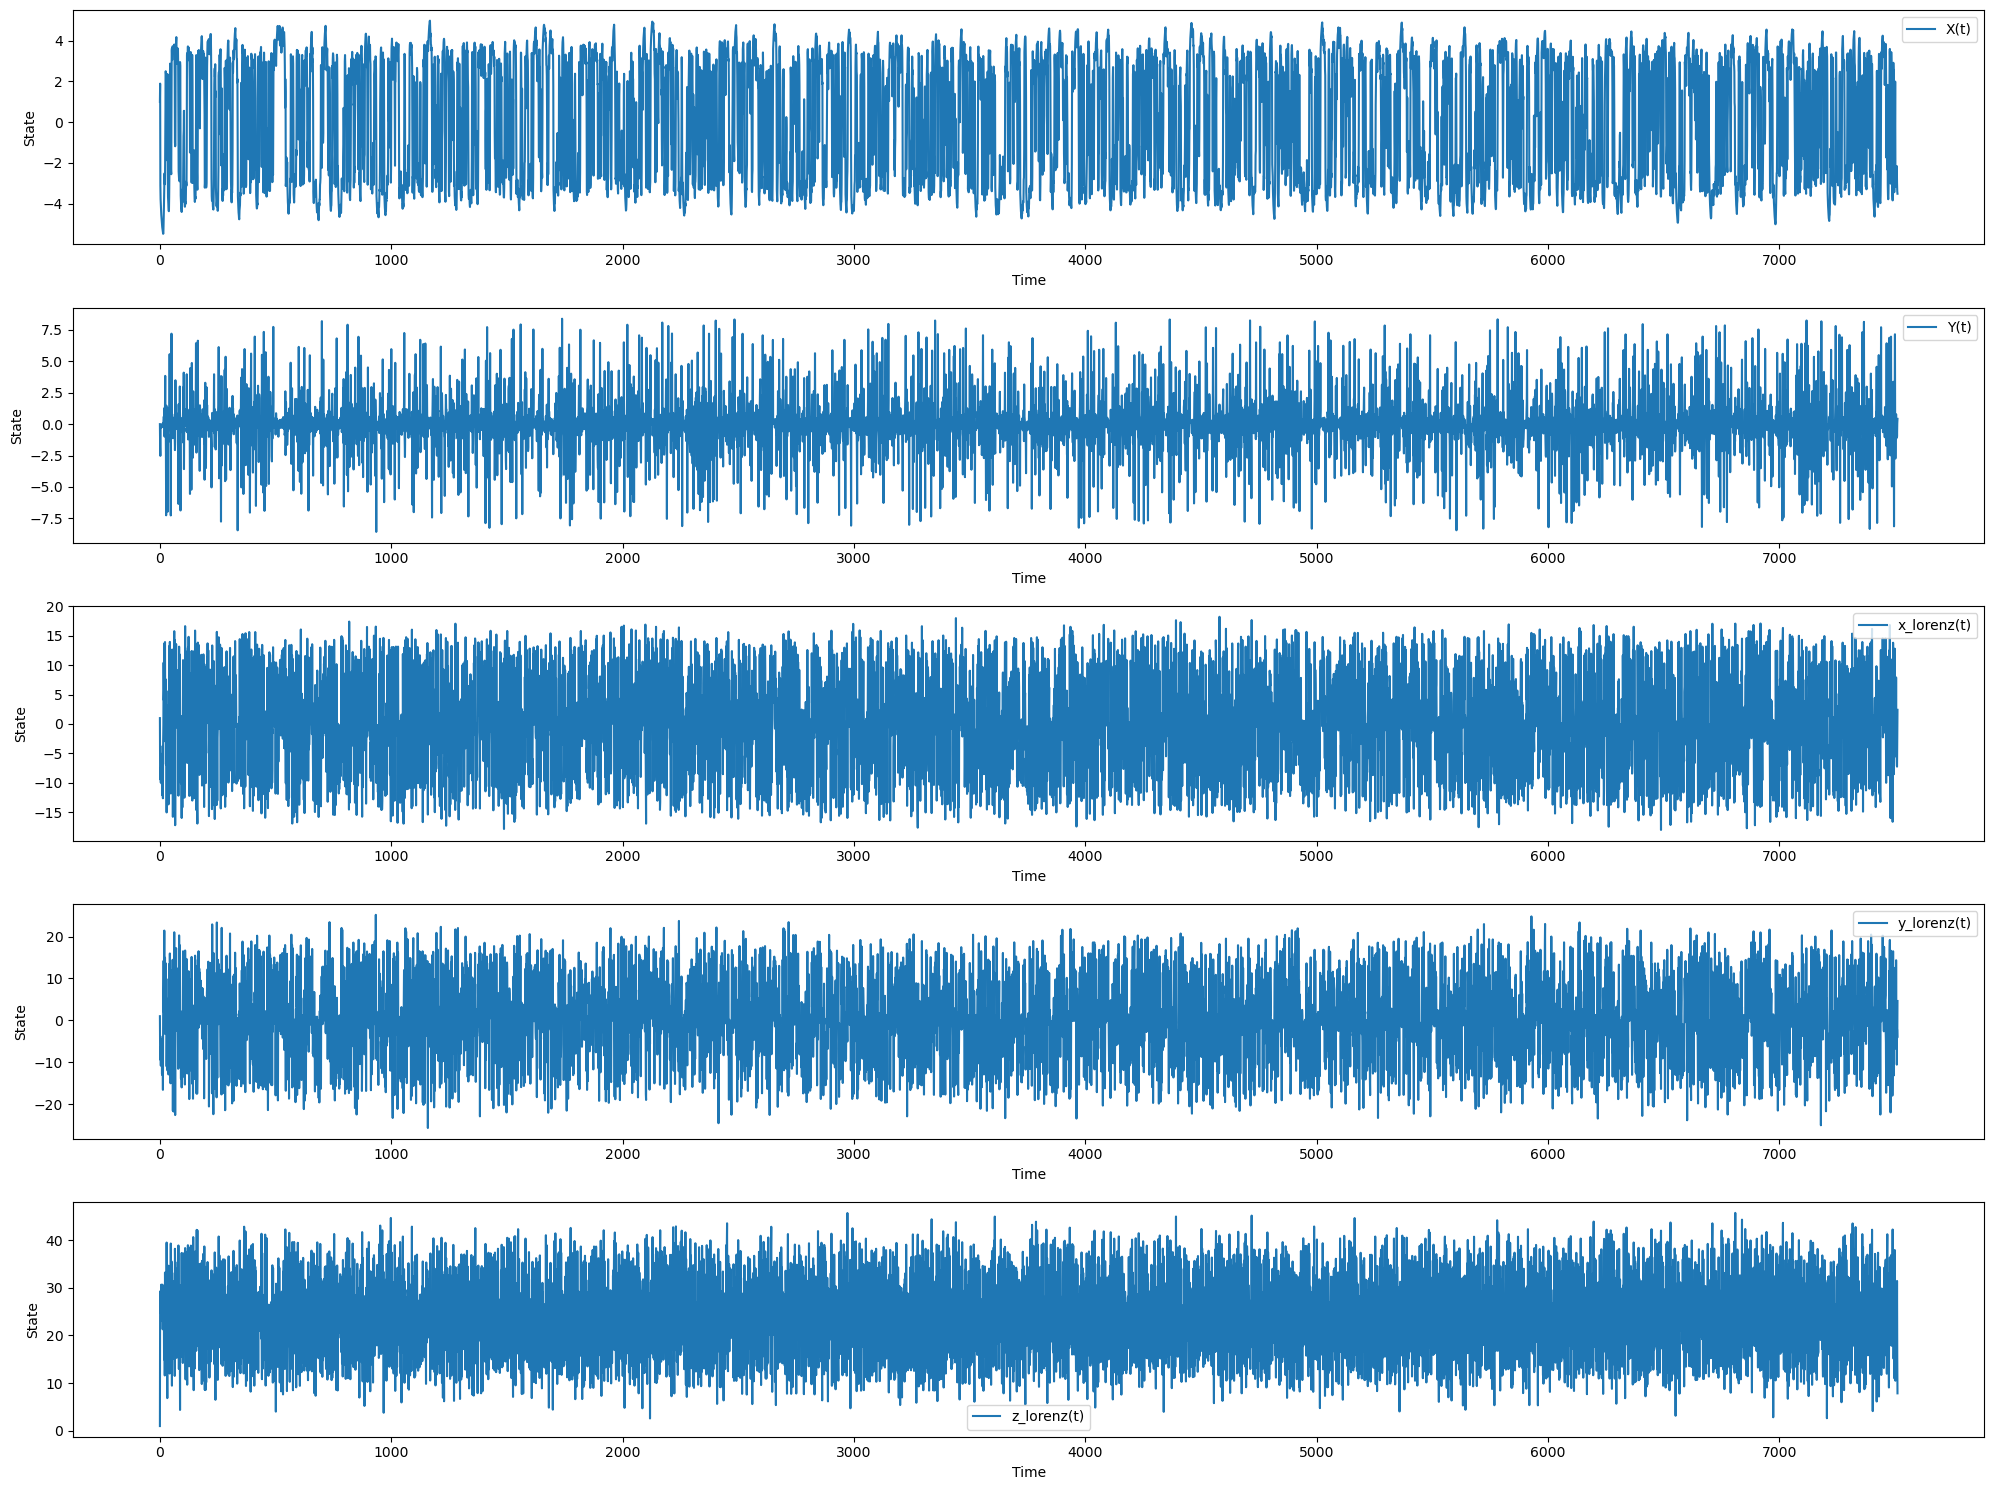

In [5]:
# Plot the results
plt.figure(figsize=(20, 15))

plt.subplot(5, 1, 1)
plt.plot(sol.t, sol.y[0], label='X(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 2)
plt.plot(sol.t, sol.y[1], label='Y(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 3)
plt.plot(sol.t, sol.y[2], label='x_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 4)
plt.plot(sol.t, sol.y[3], label='y_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.subplot(5, 1, 5)
plt.plot(sol.t, sol.y[4], label='z_lorenz(t)')
plt.xlabel('Time')
plt.ylabel('State')
plt.legend()

plt.tight_layout()
plt.show()

In [6]:
#Time, Van Der Pol　OscillatorのX, lorenzのx項のみを抽出、学習。

data = pd.DataFrame({
    'X': sol.y[0],
    'Y': sol.y[1],
    'x_lorenz': sol.y[2],
    'y_lorenz': sol.y[3],
    'z_lorenz': sol.y[4]
})

# DataFrameをCSVファイルに保存
data.to_csv('coupled_system_dataset.csv', index=False)

In [7]:
data_loaded = pd.read_csv('coupled_system_dataset.csv')

In [8]:
X = data.values

In [9]:
X.shape

(7510, 5)

これで、2510にわたる、ローレンツモデルのx項を外力に持つVDPの配列を得ることができた。

#### 学習させるのは、どのパラメータ？

描画は後にする。

In [10]:
# Objective functions accepted by ReservoirPy must respect some conventions:
#  - dataset and config arguments are mandatory, like the empty '*' expression.
#  - all parameters that will be used during the search must be placed after the *.
#  - the function must return a dict with at least a 'loss' key containing the result
# of the loss function. You can add any additional metrics or information with other 
# keys in the dict. See hyperopt documentation for more informations.
def objective(dataset, config, *, iss, N, sr, lr, ridge, seed):
    
    # This step may vary depending on what you put inside 'dataset'
    train_data, validation_data = dataset
    X_train, y_train = train_data
    X_val, y_val = validation_data
    
    # You can access anything you put in the config 
    # file from the 'config' parameter.
    instances = config["instances_per_trial"]
    
    # The seed should be changed across the instances, 
    # to be sure there is no bias in the results 
    # due to initialization.
    variable_seed = seed 
    
    losses = []; r2s = [];
    for n in range(instances):
        # Build your model given the input parameters
        reservoir = Reservoir(N, 
                              sr=sr, 
                              lr=lr, 
                              input_scaling=iss, 
                              seed=variable_seed)
        
        readout = Ridge(ridge=ridge)

        model = reservoir >> readout


        # Train your model and test your model.
        predictions = model.fit(X_train, y_train) \
                           .run(X_test)
        
        loss = nrmse(y_test, predictions, norm_value=np.ptp(X_train))
        r2 = rsquare(y_test, predictions)
        
        # Change the seed between instances
        variable_seed += 1
        
        losses.append(loss)
        r2s.append(r2)

    # Return a dictionnary of metrics. The 'loss' key is mandatory when
    # using hyperopt.
    return {'loss': np.mean(losses),
            'r2': np.mean(r2s)}

In [11]:
hyperopt_config = {
    "exp": f"hyperopt-multiscroll", # the experimentation name
    "hp_max_evals": 200,             # the number of differents sets of parameters hyperopt has to try
    "hp_method": "random",           # the method used by hyperopt to chose those sets (see below)
    "seed": 42,                      # the random state seed, to ensure reproducibility
    "instances_per_trial": 3,        # how many random ESN will be tried with each sets of parameters
    "hp_space": {                    # what are the ranges of parameters explored
        "N": ["choice", 1000],             # the number of neurons is fixed to 500
        "sr": ["loguniform", 1e-2, 10],   # the spectral radius is log-uniformly distributed between 1e-2 and 10
        "lr": ["loguniform", 1e-3, 1],  # idem with the leaking rate, from 1e-3 to 1
        "iss": ["uniform", 0, 1],           # the input scaling uniformly distributed between 0 and 1
        "ridge": ["loguniform", 1e-9, 1e-2],        # and so is the regularization parameter.
        "seed": ["choice", 1234]          # an other random seed for the ESN initialization
    }
}


import json

# we precautionously save the configuration in a JSON file
# each file will begin with a number corresponding to the current experimentation run number.
with open(f"{hyperopt_config['exp']}.config.json", "w+") as f:
    json.dump(hyperopt_config, f)

データを準備する。

学習期間は6000ステップ。
テスト期間は1000ステップ。

In [12]:
X.shape

(7510, 5)

In [13]:
from reservoirpy.datasets import to_forecasting

train_len = 1000

x, y = to_forecasting(X, forecast=10)
X_train, y_train = x[:train_len], y[:train_len]
X_test, y_test = x[train_len:train_len+2000], y[train_len:train_len+2000]
X_gen_test, y_gen_test = x[train_len+2000:], y[train_len+2000:]

dataset = ((X_train, y_train), (X_test, y_test))

In [14]:
from reservoirpy.hyper import research

best = research(objective, dataset, f"{hyperopt_config['exp']}.config.json", ".")

100%|██████████| 200/200 [07:58<00:00,  2.39s/trial, best loss: 0.10108588378952015]


刻み幅から考えると、学習期間は10倍したほうが良いかもしれない。

In [15]:
best

({'N': 0,
  'iss': 0.0011867504507336868,
  'lr': 0.4402251533661025,
  'ridge': 1.398293408194846e-05,
  'seed': 0,
  'sr': 0.1378790157061615},
 <hyperopt.base.Trials at 0x16757b100>)

別に取得していた最適化のデータを用いる。

timestep = 75100

train_len = 20000

test_len = 5000

In [16]:
# bestから取得したハイパーパラメータを設定
N = 500
iss = 0.5314055739748769
lr = 0.5869419714703692
ridge = 2.5739572117002763e-07
seed = 1234
sr = 0.030264242037118992

In [17]:
def reset_esn():
    from reservoirpy.nodes import Reservoir, Ridge

    reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
    readout = Ridge(ridge=ridge)

    return reservoir >> readout

In [18]:
# データセットからトレーニングとバリデーションデータを取得
train_data, validation_data = dataset
X_train, y_train = train_data
X_val, y_val = validation_data

# モデルの構築
reservoir = Reservoir(N, 
                      sr=sr, 
                      lr=lr, 
                      input_scaling=iss, 
                      seed=seed)
readout = Ridge(ridge=ridge)
model = reservoir >> readout

# モデルの訓練と予測
predictions = model.fit(X_train, y_train).run(X_val)

# 評価（lossとr2の計算方法は既存のものを使用しています）
loss = nrmse(y_val, predictions, norm_value=np.ptp(X_train))
r2 = rsquare(y_val, predictions)

print("Loss:", loss)
print("R^2:", r2)

Loss: 0.14737250295825652
R^2: 0.2639305368779735


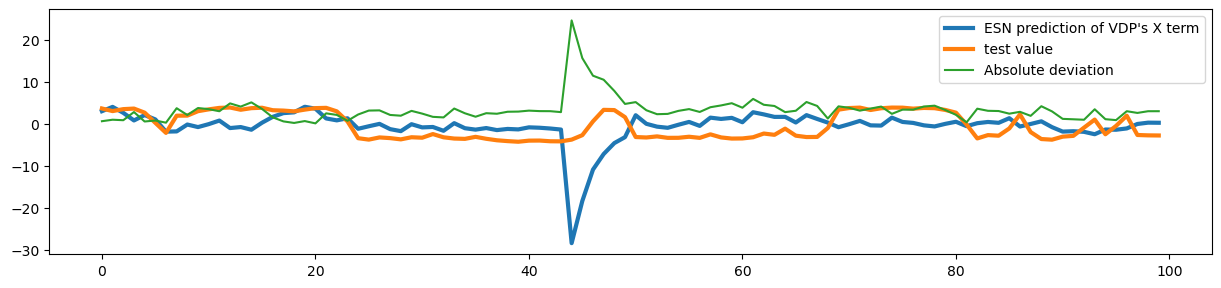

In [19]:
sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, :1][:sample], lw=3, label="ESN prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - predictions[:, :1][:sample]), label="Absolute deviation")


plt.legend()
plt.show()

In [20]:
nrmse(y_test[:, :1], predictions[:, :1])

0.6019552099450198

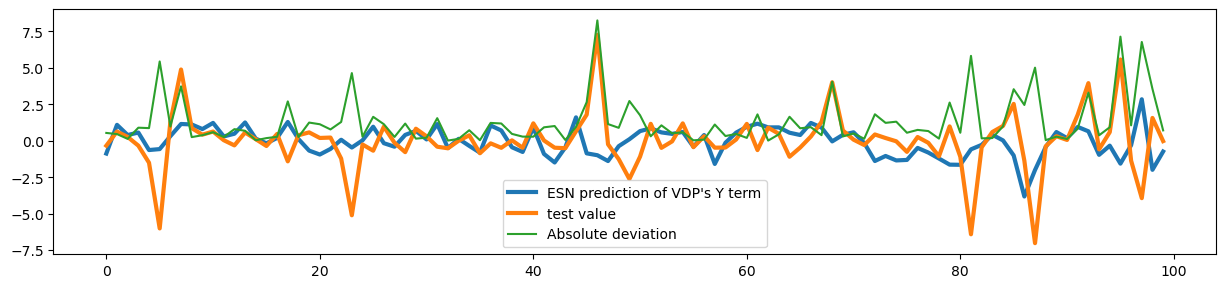

In [21]:
sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), predictions[:, 1:2][:sample], lw=3, label="ESN prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - predictions[:, 1:2][:sample]), label="Absolute deviation")


plt.legend()
plt.show()

ここまで、通常の1期先予測の方法を見た。

さて、ここから、ESNに自分の予測に基づいて、100期先までを予測してもらう。

# Generative Modelを使う。

今まで全ての情報を用いて、100期先までの予測を行う（実際気にするのはより小さい数）。

In [22]:
seed_timesteps = 1000

warming_inputs = train_data

warming_out = predictions = model.fit(X_train, y_train).run(X_val)  # warmup

In [23]:
nb_generations = 100

X_gen = np.zeros((nb_generations, 5))
y = warming_out[-100:]
for t in range(nb_generations):  # generation
    y = model.run(y)
    X_gen[t, :] = y[-1]

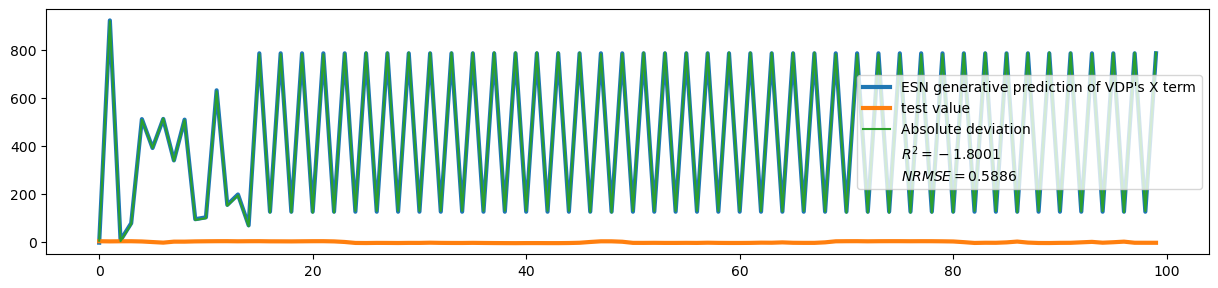

In [33]:
#Warmupの部分を無くす。

sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), X_gen[:, :1][:sample], lw=3, label="ESN generative prediction of VDP's X term")
plt.plot(np.arange(sample), y_test[:, :1][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, :1][:sample] - X_gen[:, :1][:sample]), label="Absolute deviation")

plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_gen[:, :1][:sample], y_test[:, 1:2][:sample]), 4)}$")
plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_gen[:, :1][:sample], y_test[:, 1:2][:sample]), 4)}$")


plt.legend()
plt.show()

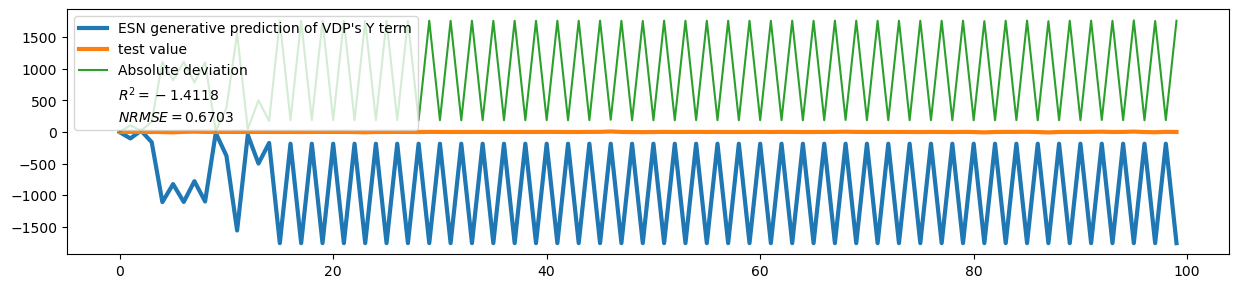

In [34]:
#Warmupの部分を無くす。

sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), X_gen[:, 1:2][:sample], lw=3, label="ESN generative prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - X_gen[:, 1:2][:sample]), label="Absolute deviation")

plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_gen[:, 1:2][:sample], y_test[:, 1:2][:sample]), 4)}$")
plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_gen[:, 1:2][:sample], y_test[:, 1:2][:sample]), 4)}$")


plt.legend()
plt.show()

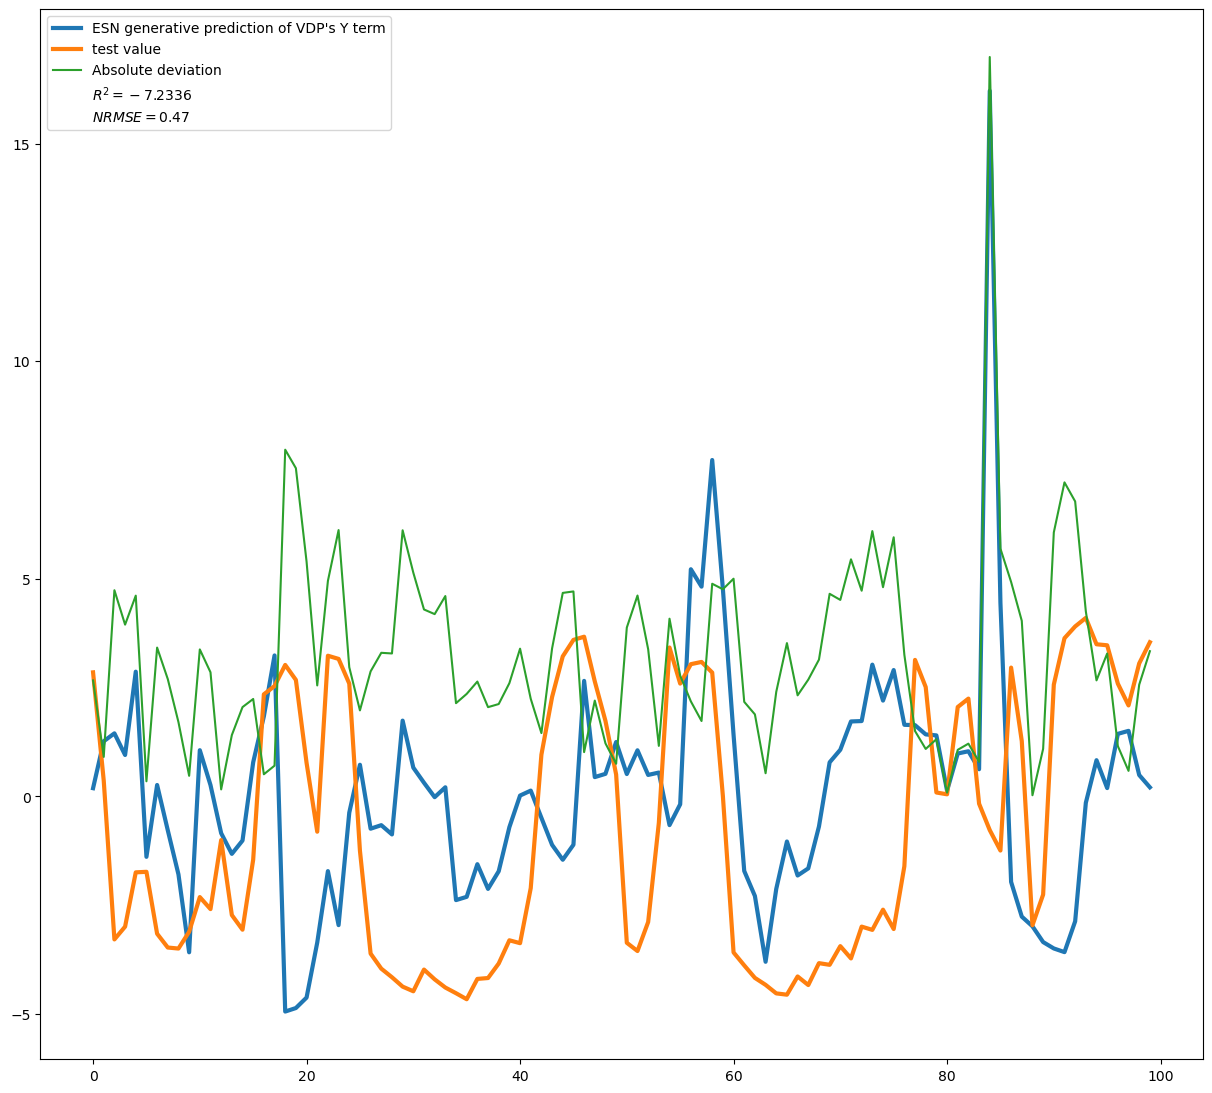

In [31]:
sample = 100

fig = plt.figure(figsize=(15, 30))
plt.subplot(211)
plt.plot(np.arange(sample), warming_out[:, :1][-sample:], lw=3, label="ESN generative prediction of VDP's Y term")
plt.plot(np.arange(sample), y_train[:, :1][-sample:], lw=3, label="test value")
plt.plot(np.abs(y_train[:, :1][-sample:] - warming_out[:, :1][-sample:]), label="Absolute deviation")

plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(warming_out[:, 1:2][-sample:], y_train[:, :1][-sample:]), 4)}$")
plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(warming_out[:, 1:2][-sample:], y_train[:, :1][-sample:]), 4)}$")

plt.legend()
plt.show()

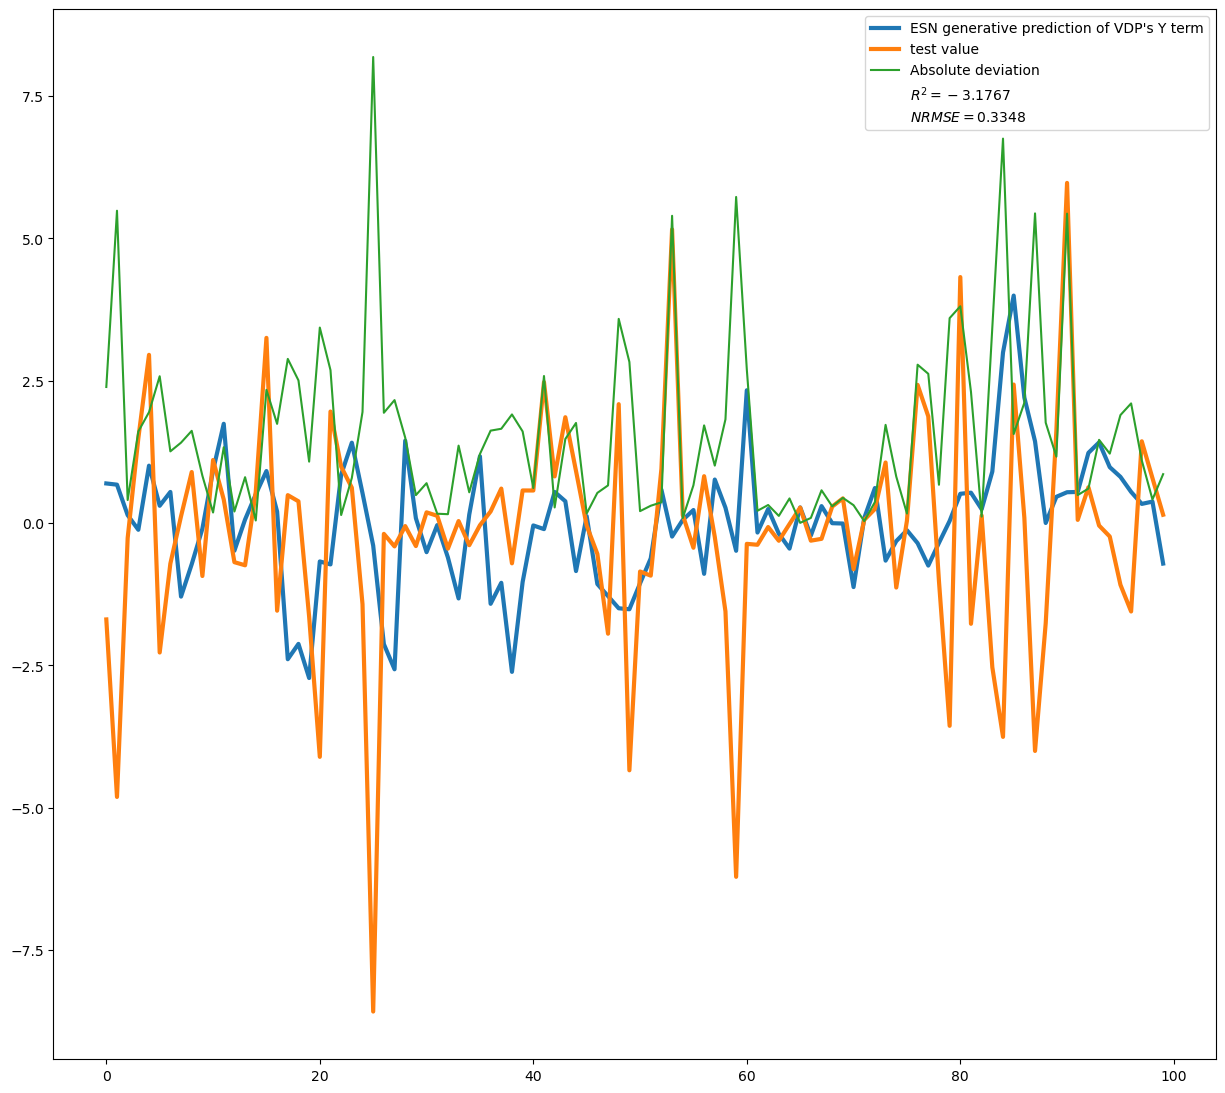

In [24]:
sample = 100

fig = plt.figure(figsize=(15, 30))
plt.subplot(211)
plt.plot(np.arange(sample), warming_out[:, 1:2][-sample:], lw=3, label="ESN generative prediction of VDP's Y term")
plt.plot(np.arange(sample), y_train[:, 1:2][-sample:], lw=3, label="test value")
plt.plot(np.abs(y_train[:, 1:2][-sample:] - warming_out[:, 1:2][-sample:]), label="Absolute deviation")

plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(warming_out[:, 1:2][-sample:], y_train[:, 1:2][-sample:]), 4)}$")
plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(warming_out[:, 1:2][-sample:], y_train[:, 1:2][-sample:]), 4)}$")

plt.legend()
plt.show()

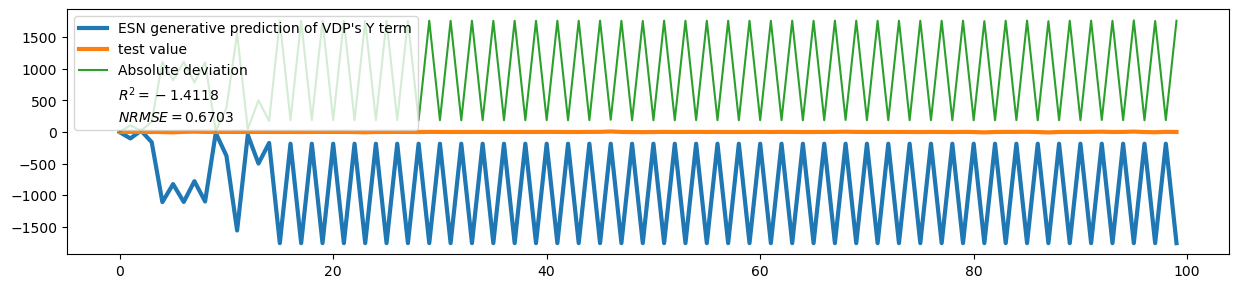

In [25]:
sample = 100

fig = plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.plot(np.arange(sample), X_gen[:, 1:2][:sample], lw=3, label="ESN generative prediction of VDP's Y term")
plt.plot(np.arange(sample), y_test[:, 1:2][:sample], lw=3, label="test value")
plt.plot(np.abs(y_test[:, 1:2][:sample] - X_gen[:, 1:2][:sample]), label="Absolute deviation")

plt.plot([], [], ' ', label=f"$R^2 = {round(rsquare(X_gen[:, 1:2][:sample], y_test[:, 1:2][:sample]), 4)}$")
plt.plot([], [], ' ', label=f"$NRMSE = {round(nrmse(X_gen[:, 1:2][:sample], y_test[:, 1:2][:sample]), 4)}$")


plt.legend()
plt.show()